In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations


In [2]:
import tensorflow as tf
import os
import time
import cv2
import uuid
import matplotlib.pyplot as plt


In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [3]:
# import cv2
# import os
# import uuid
# import time
# import matplotlib.pyplot as plt

# Ensure the path exists where images will be saved
IMAGES_PATH = os.path.join('data','images')
number_images = 0  # Adjust this number as needed

# Open the webcam (use 0 for the default webcam, 1 for an external one)
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    ret, frame = cap.read()
    
    if not ret:
        print("Failed to capture image")
        continue

    # Save the captured image
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    
    # Display the image in the notebook
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Image {imgnum}')
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

    time.sleep(0.5)  # Slight delay to avoid capturing images too quickly

# Release the webcam
cap.release()


In [4]:
!labelme


2024-08-24 11:50:22,840 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\jhaad\.labelmerc


In [ ]:
#REVIEW DATASET

In [5]:
# import tensorflow as tf
# import cv2
import json
import numpy as np
# from matplotlib import pyplot as plt

In [6]:
tf.config.list_physical_devices('GPU')

[]

In [7]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg',shuffle=True)

In [8]:
images.as_numpy_iterator().next()

b'data\\images\\89d63f1b-61de-11ef-a1dc-e2a137351305.jpg'

In [10]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img
    

In [11]:
images = images.map(load_image)

In [12]:
images.as_numpy_iterator().next()

array([[[200, 202, 181],
        [199, 201, 180],
        [197, 200, 179],
        ...,
        [168, 174, 140],
        [170, 174, 139],
        [171, 175, 140]],

       [[199, 201, 180],
        [199, 201, 180],
        [198, 201, 180],
        ...,
        [169, 174, 142],
        [169, 175, 141],
        [168, 174, 140]],

       [[196, 198, 176],
        [198, 200, 178],
        [199, 202, 181],
        ...,
        [168, 174, 146],
        [167, 174, 143],
        [166, 173, 140]],

       ...,

       [[166, 192, 189],
        [168, 194, 191],
        [171, 195, 195],
        ...,
        [ 70,  70,  72],
        [ 73,  68,  74],
        [ 74,  67,  74]],

       [[170, 194, 194],
        [170, 194, 194],
        [171, 195, 195],
        ...,
        [ 73,  73,  75],
        [ 74,  69,  73],
        [ 76,  71,  75]],

       [[170, 194, 194],
        [168, 192, 192],
        [169, 193, 193],
        ...,
        [ 85,  85,  87],
        [ 75,  73,  76],
        [ 74,  69,  73]]

In [13]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [14]:
image_generator = images.batch(4).as_numpy_iterator()

In [15]:
plot_images = image_generator.next()

In [16]:
plot_images

array([[[[200, 202, 181],
         [199, 201, 180],
         [197, 200, 179],
         ...,
         [168, 174, 140],
         [170, 174, 139],
         [171, 175, 140]],

        [[199, 201, 180],
         [199, 201, 180],
         [198, 201, 180],
         ...,
         [169, 174, 142],
         [169, 175, 141],
         [168, 174, 140]],

        [[196, 198, 176],
         [198, 200, 178],
         [199, 202, 181],
         ...,
         [168, 174, 146],
         [167, 174, 143],
         [166, 173, 140]],

        ...,

        [[166, 192, 189],
         [168, 194, 191],
         [171, 195, 195],
         ...,
         [ 70,  70,  72],
         [ 73,  68,  74],
         [ 74,  67,  74]],

        [[170, 194, 194],
         [170, 194, 194],
         [171, 195, 195],
         ...,
         [ 73,  73,  75],
         [ 74,  69,  73],
         [ 76,  71,  75]],

        [[170, 194, 194],
         [168, 192, 192],
         [169, 193, 193],
         ...,
         [ 85,  85,  87],
        

In [ ]:
fix, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx,image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
#SPLITTING DATA INTO TRAIN TEST VAL

In [ ]:
50*.7 #train


In [ ]:
50*.15  #8 & 7 to test and val

In [ ]:
#moving matching labes into val test train labels

In [18]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','images', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)   

In [19]:
import albumentations as alb

In [20]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [21]:
img = cv2.imread(os.path.join('data','train', 'images','168c555f-5fc6-11ef-99ed-e0dcbd3da3e5.jpg'))


In [22]:
with open(os.path.join('data', 'train', 'labels', '168c555f-5fc6-11ef-99ed-e0dcbd3da3e5.json'), 'r') as f:
    label = json.load(f)

In [23]:
label['shapes'][0]['label']


'face'

In [24]:
label['shapes'][0]['points']


[[203.65384615384616, 169.80769230769232], [482.5, 452.5]]

In [25]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [26]:
coords

[203.65384615384616, 169.80769230769232, 482.5, 452.5]

In [27]:
coords = list(np.divide(coords,[640,480,640,480]))

In [28]:
coords

[0.31820913461538464, 0.35376602564102566, 0.75390625, 0.9427083333333334]

In [29]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])


In [30]:
augmented['bboxes']

[(0.06333333333333335,
  0.03888888888888886,
  0.6829914529914529,
  0.667094017094017)]

In [31]:
augmented['bboxes'][0][2:]


(0.6829914529914529, 0.667094017094017)

In [ ]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [33]:
#BUILD AND RUN AUGMENTATION PIPELINE

In [34]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [35]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

train_labels = train_labels.map(lambda x, y: (tf.reshape(x, [1]), tf.reshape(y, [4])))


NameError: name 'train_labels' is not defined

In [36]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

test_labels = test_labels.map(lambda x, y: (tf.reshape(x, [1]), tf.reshape(y, [4])))


NameError: name 'test_labels' is not defined

In [37]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

val_labels = val_labels.map(lambda x, y: (tf.reshape(x, [1]), tf.reshape(y, [4])))


NameError: name 'val_labels' is not defined

In [38]:
train_images.as_numpy_iterator().next()

array([[[1.        , 0.9019608 , 0.9764706 ],
        [1.        , 0.9019608 , 0.9764706 ],
        [1.        , 0.9019608 , 0.9764706 ],
        ...,
        [0.89166665, 0.8       , 0.7794118 ],
        [0.8962622 , 0.80177695, 0.78039217],
        [0.8935662 , 0.7970588 , 0.779902  ]],

       [[1.        , 0.9019608 , 0.9764706 ],
        [1.        , 0.9019608 , 0.9764706 ],
        [1.        , 0.9019608 , 0.9764706 ],
        ...,
        [0.88976717, 0.80741423, 0.7956495 ],
        [0.8940564 , 0.8014093 , 0.7862132 ],
        [0.9004902 , 0.8039216 , 0.7857843 ]],

       [[1.        , 0.9019608 , 0.9764706 ],
        [1.        , 0.9019608 , 0.9764706 ],
        [1.        , 0.9019608 , 0.9764706 ],
        ...,
        [0.8853554 , 0.8064951 , 0.779902  ],
        [0.90006125, 0.8113358 , 0.7873162 ],
        [0.8958946 , 0.8056985 , 0.77432597]],

       ...,

       [[0.48088235, 0.34754902, 0.44411764],
        [0.49454656, 0.35729167, 0.45042893],
        [0.4970588 , 0

In [39]:
#PREPARE LABELS

In [40]:
def load_labels(label_path):
    with open(label_path.numpy(),'r',encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']],label['bbox']

In [41]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))


In [42]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.5596, 0.2037, 1.    , 0.879 ], dtype=float16))

In [43]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)


(2100, 2100, 480, 480, 420, 420)

In [44]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)


In [45]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.5005 , 0.05463, 1.     , 0.794  ],
        [0.2013 , 0.0353 , 0.851  , 0.642  ],
        [0.3625 , 0.3254 , 0.8755 , 0.9277 ],
        [0.     , 0.1081 , 0.54   , 1.     ],
        [0.03102, 0.1187 , 0.642  , 0.6313 ],
        [0.3354 , 0.1299 , 0.947  , 0.6426 ],
        [0.5225 , 0.391  , 0.9453 , 0.9683 ],
        [0.2274 , 0.2252 , 0.8555 , 0.956  ]], dtype=float16))

In [46]:
data_samples= train.as_numpy_iterator()

In [47]:
res = data_samples.next()

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Create the subplots with the correct configuration
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

for idx in range(4): 
    sample_image = res[0][idx].copy()  # Create a writable copy of the image
    sample_coords = res[1][1][idx]
    
    # Ensure the coordinates are properly multiplied and converted to integers
    top_left = tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int))
    bottom_right = tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int))
    
    # Draw the rectangle on the image
    cv2.rectangle(sample_image, top_left, bottom_right, (255, 0, 0), 2)
    
    # Display the image
    ax[idx].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper color display

# Show the plot
plt.show()


In [ ]:
#BUILDING DEEP LEARNING USING API NOW

In [49]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16 #classification model

In [50]:
vgg = VGG16(include_top=False) 

In [51]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [54]:
facetracker = build_model()
facetracker.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 120, 120, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vgg16 (Functional)            │ (None, 3, 3, 512)         │      14,714,688 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d          │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_max_pooling2d_1        │ (None, 512)               │               0 │ vgg16[0][0]                │
│ (GlobalMaxPooling2D)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 2048)              │       1,050,624 │ global_max_pooling2d[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 2048)              │       1,050,624 │ global_max_pooling2d_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │           2,049 │ dense[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 4)                 │           8,196 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [55]:
X, y = train.as_numpy_iterator().next()


In [56]:
classes, coords = facetracker.predict(X)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


In [57]:
classes, coords

(array([[0.33157796],
        [0.29951227],
        [0.38669473],
        [0.3857398 ],
        [0.3118644 ],
        [0.33511272],
        [0.36197266],
        [0.4053902 ]], dtype=float32),
 array([[0.56693715, 0.42263803, 0.4007333 , 0.403141  ],
        [0.6227774 , 0.41060615, 0.3593546 , 0.49722317],
        [0.6137418 , 0.41115415, 0.3630304 , 0.4445098 ],
        [0.571625  , 0.40046763, 0.41944093, 0.45475882],
        [0.56898785, 0.41868576, 0.3804556 , 0.43215868],
        [0.5666702 , 0.43269092, 0.41750026, 0.432699  ],
        [0.5875318 , 0.4305157 , 0.38009438, 0.4175689 ],
        [0.5795542 , 0.44676477, 0.2962952 , 0.4419627 ]], dtype=float32))

In [134]:
#LOSSES

In [58]:
batches_per_epoch = 415
lr_decay = (1./0.75 -1)/batches_per_epoch

In [59]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)


C:\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [60]:
lr_decay

0.0008032128514056223

In [61]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [62]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [63]:
localization_loss(y[1], coords).numpy()


8.80802

In [64]:
classloss(y[0], classes).numpy()

1.0487213

In [65]:
regressloss(y[1], coords).numpy()

8.80802

In [66]:
class FaceTracker(Model): 
    def __init__(self, eyetracker, **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        y[0].set_shape([None,1])  


        print(f"Shape of y[0]: {y[0].shape}")
        print(f"Shape of y[1]: {y[1].shape}")
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        y[0].set_shape([None,1])  

        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [67]:
model=FaceTracker(facetracker)

In [68]:
model.compile(opt,classloss,regressloss)

In [69]:
logdir='logs'

In [72]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=1, validation_data=val, callbacks=[tensorboard_callback])


263/263 ━━━━━━━━━━━━━━━━━━━━ 151s 572ms/step - class_loss: 1.1091e-04 - regress_loss: 0.0860 - total_loss: 0.0861 - val_class_loss: 1.7165e-05 - val_regress_loss: 0.0599 - val_total_loss: 0.0599


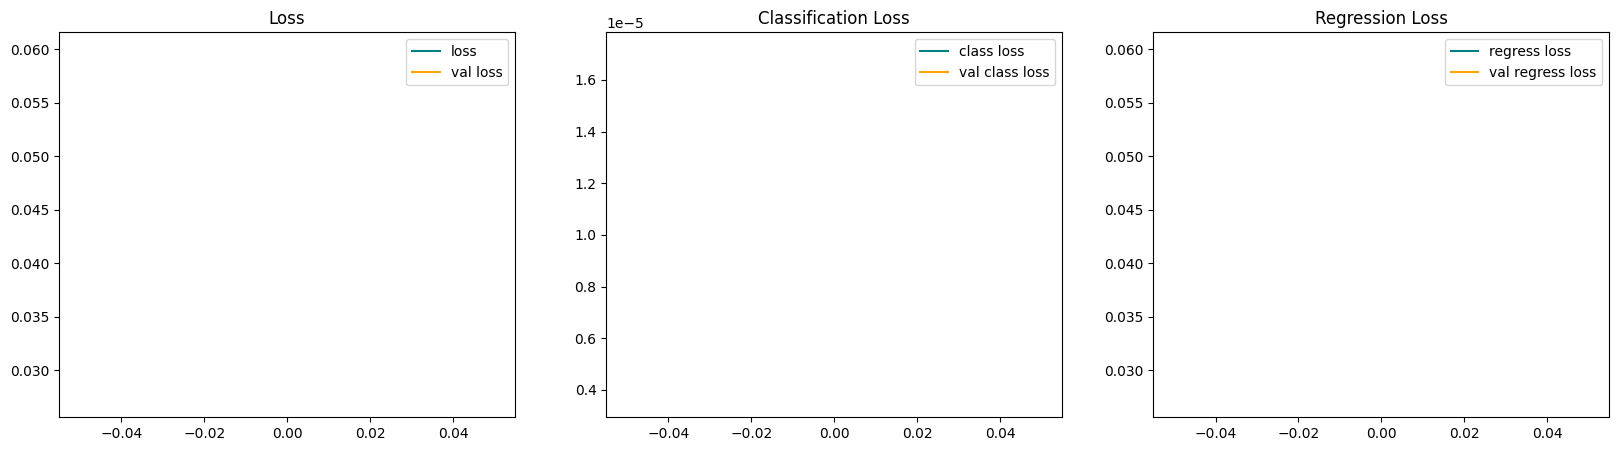

In [73]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [74]:
test_data = test.as_numpy_iterator()

In [75]:
test_sample = test_data.next()

In [76]:
yhat = facetracker.predict(test_sample[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


In [ ]:
# fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# for idx in range(4): 
#     sample_image = test_sample[0][idx]
#     sample_coords = yhat[1][idx]
    
#     if yhat[0][idx] > 0.9:
#         cv2.rectangle(sample_image, 
#                       tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
#                       tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
#                             (255,0,0), 2)
    
#     ax[idx].imshow(sample_image)
import numpy as np
import cv2
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx].copy()  # Make a writable copy of the image
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                      (255,0,0), 2)
    
    ax[idx].imshow(sample_image)
    ax[idx].axis('off')  # Hide the axis for a cleaner display

plt.show()


In [78]:
from tensorflow.keras.models import load_model

In [79]:
facetracker.save('facetracker.h5')

In [80]:
facetracker = load_model('facetracker.h5')


In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load your model
# facetracker = tf.keras.models.load_model('facetracker.h5')

# Initialize video capture
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Camera not accessible.")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120, 120))
    
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5:
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                      (255, 0, 0), 2)
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [80, 0])),
                      (255, 0, 0), -1)
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int), [0, -5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
